# Clustering on various news sources

Tried to distinguish some different news sources that are related to NBA, but found out that the clustering is not ideal. An assumption would be the word usage is pretty much identical for most of them. Therefore, a further trial was conducted on the news sources not limited to NBA-oriented.

- Sports
- Gaming
- Technology (consumer electronics)
- Science

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import homogeneity_score, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

## K-means with 3 values of $k$
- visualization of the clusters

In [2]:
random_state = 2021

# get more news data

def get_news_from_source(source):
    url = "https://newsapi.org/v2/everything?q=&domains="+source+"&pageSize=100&sortBy=popularity&apiKey=3f016bf881ba40f7add6ee94bc3f4fc3"
    response = requests.get(url)
    jsontxt = response.json()

    news_df = pd.DataFrame()

    for items in jsontxt['articles']:
        Source=items["source"]["name"]
        Date=items["publishedAt"]
        NewDate=Date.split("T")
        Date=NewDate[0]

        Title=items["title"]
        Title=re.sub(r'[,.;@#?!&$\-\']+', ' ', Title, flags=re.IGNORECASE)
        Title=re.sub(' +', ' ', Title, flags=re.IGNORECASE)
        Title=re.sub(r'\"', ' ', Title, flags=re.IGNORECASE)
        Title=re.sub(r'[^a-zA-Z]', " ", Title, flags=re.VERBOSE)
        Title=Title.replace(',', '')
        Title=' '.join(Title.split())
        Title=re.sub("\n|\r", "", Title)

        Headline=items["description"]
        Headline=re.sub(r'[,.;@#?!&$\-\']+', ' ', Headline, flags=re.IGNORECASE)
        Headline=re.sub(' +', ' ', Headline, flags=re.IGNORECASE)
        Headline=re.sub(r'\"', ' ', Headline, flags=re.IGNORECASE)
        Headline=re.sub(r'[^a-zA-Z]', " ", Headline, flags=re.VERBOSE)
        Headline=Headline.replace(',', '')
        Headline=' '.join(Headline.split())
        Headline=re.sub("\n|\r", "", Headline)

        news_df =news_df.append({'Source':Source, 'Date':Date, 'Title':Title, 'Headline':Headline}, ignore_index=True)
    news_df.to_csv('../data/nba-news-source/'+source+'-2021-10-09.csv', index=False)
    return(news_df)


In [3]:
espn = get_news_from_source('espn.com')
polygon = get_news_from_source('polygon.com')
nasa = get_news_from_source('nasa.gov')
macrumors = get_news_from_source('macrumors.com')

df = pd.concat([espn, polygon, nasa, macrumors], axis=0, ignore_index=True)
df['Text'] = df['Title'] + ' ' + df['Headline']
df = df.drop(columns=['Title', 'Headline'])
df

,Source,Date,Text
0,ESPN,2021-09-09,The battle for the Cy Hawk another test for Oh...
1,ESPN,2021-09-09,Dak is back Why the Cowboys have zero concerns...
2,ESPN,2021-09-09,Why the WNBA draft class has struggled to make...
3,ESPN,2021-09-09,Is UCLA finally on track with Chip Kelly After...
4,ESPN,2021-09-12,Broncos WR Jeudy carted off with lower leg inj...
...,...,...,...
395,MacRumors,2021-10-05,Apple Agrees to Pay Million to Settle Lawsuit ...
396,MacRumors,2021-10-05,Apple Commemorates th Anniversary of Steve Job...
397,MacRumors,2021-09-30,Apple Seeds macOS Big Sur Beta to Developers W...
398,MacRumors,2021-10-01,MacRumors Giveaway Win a Flight Bag Leather Br...


### Vectorizers

In [4]:
vec_count = CountVectorizer(input='content', stop_words='english',
                            ngram_range=(1, 1), max_features=500)
vec_tfidf = TfidfVectorizer(input='content', stop_words='english',
                            ngram_range=(1, 1), max_features=500)

dtm_count = vec_count.fit_transform(df['Text'])
dtm_tfidf = vec_tfidf.fit_transform(df['Text'])

col_names_count = vec_count.get_feature_names()
col_names_tfidf = vec_tfidf.get_feature_names()

df_count = pd.DataFrame(dtm_count.toarray(), columns=col_names_count)
df_tfidf = pd.DataFrame(dtm_tfidf.toarray(), columns=col_names_tfidf)


Use differnt $k$ values

The homogeneity score and Silhouette score of CountVectorizer is:
0.2914526756355663 0.16836203241503322
The homogeneity score and Silhouette score of TfidfVectorizer is:
0.06146851457954772 0.029815094893238428
The homogeneity score and Silhouette score of CountVectorizer is:
0.36946391298809556 0.17904908336242356
The homogeneity score and Silhouette score of TfidfVectorizer is:
0.39324808032485964 0.034968169736253746
The homogeneity score and Silhouette score of CountVectorizer is:
0.29680912347283095 0.17863738778270835
The homogeneity score and Silhouette score of TfidfVectorizer is:
0.5800599275998554 0.04392759797869041
The homogeneity score and Silhouette score of CountVectorizer is:
0.45727954760694456 0.08412074984413664
The homogeneity score and Silhouette score of TfidfVectorizer is:
0.5257363389005074 0.04084535197279959


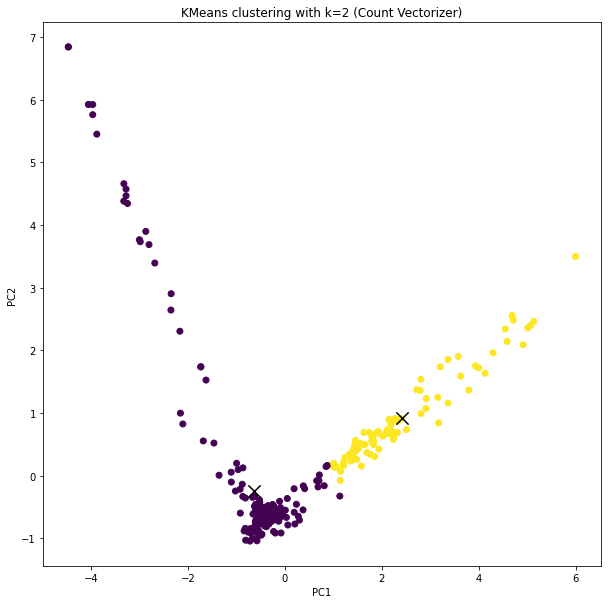

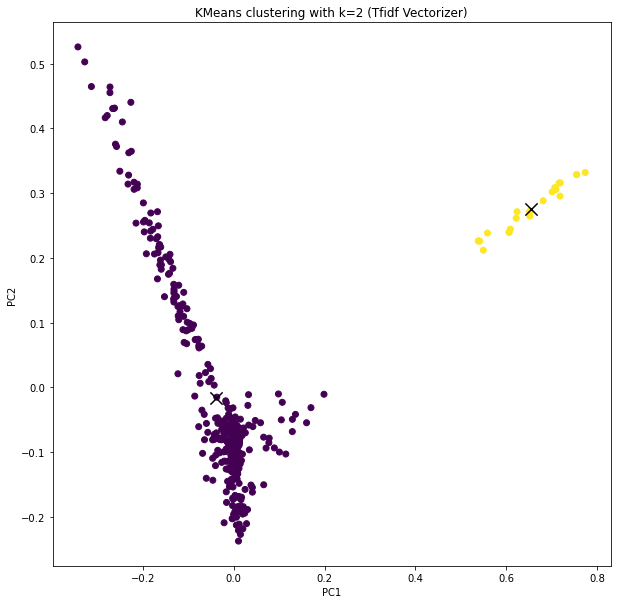

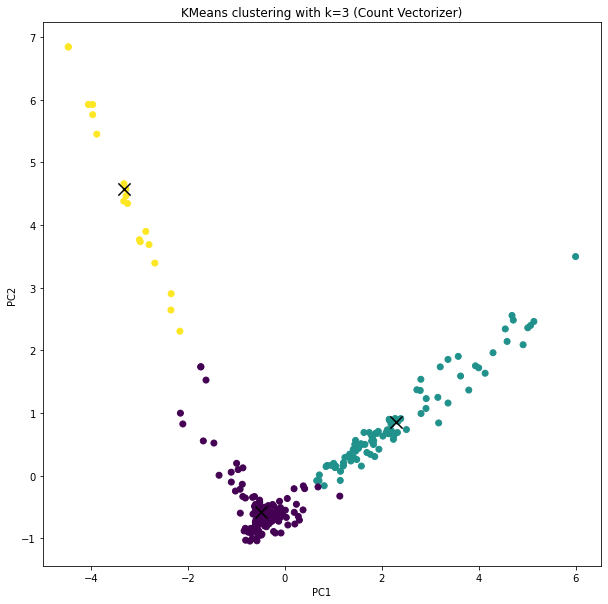

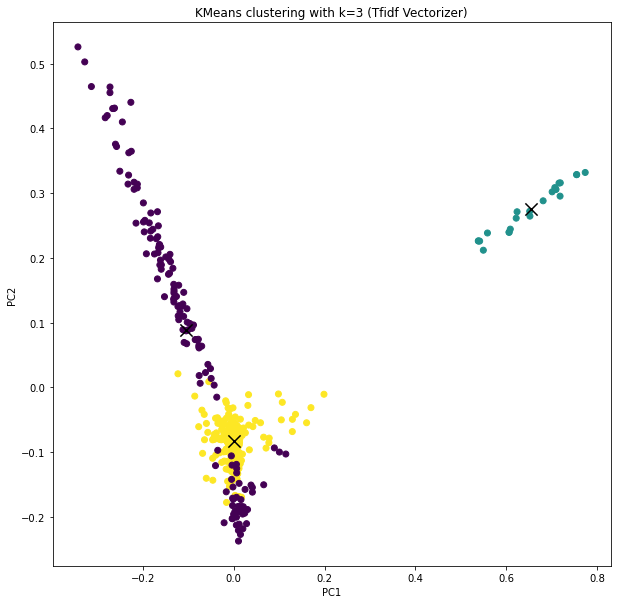

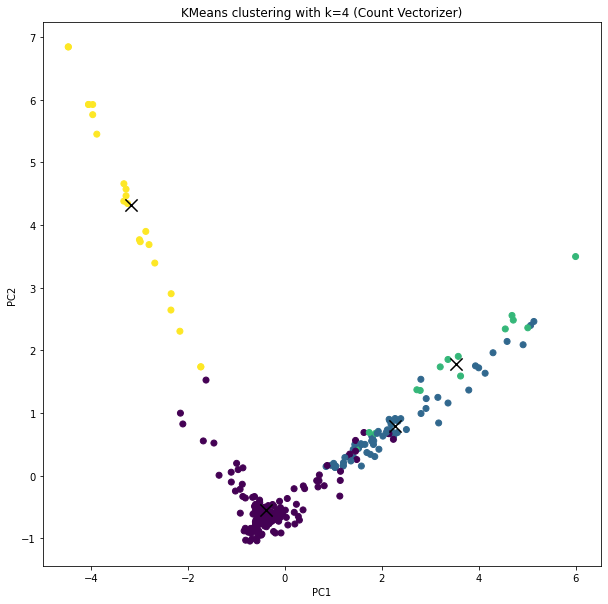

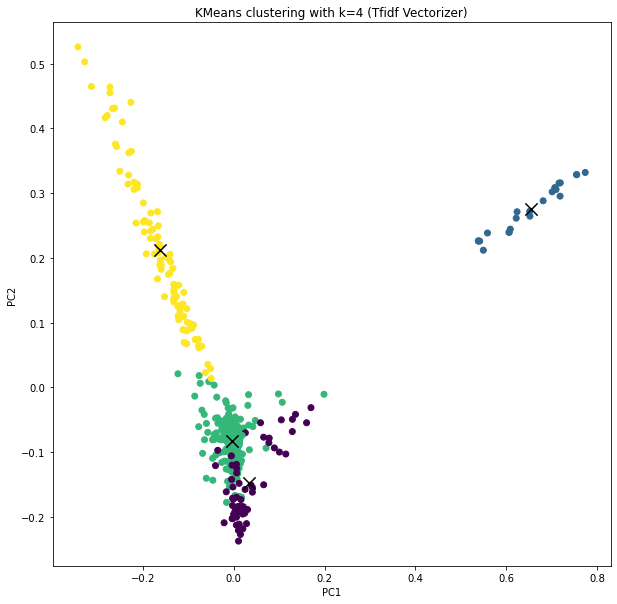

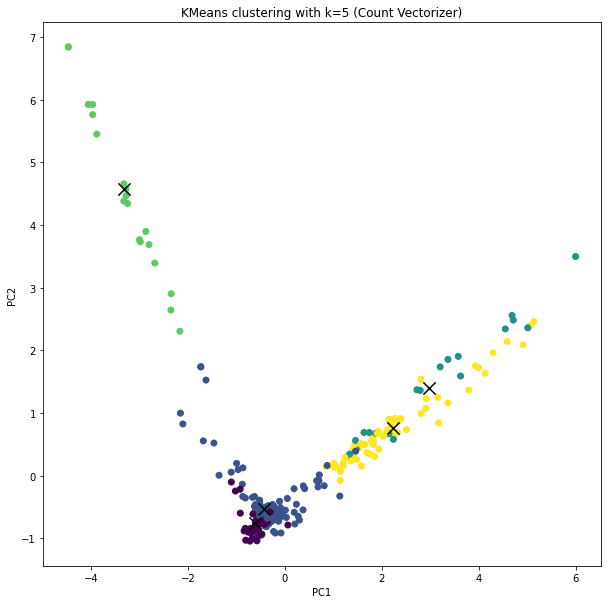

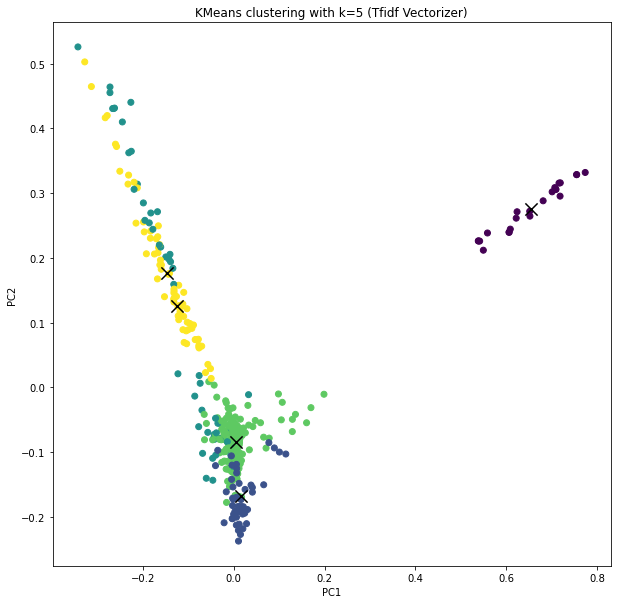

In [5]:
def iterate_w_k(k):
    kmeans_obj_count = KMeans(n_clusters=k, random_state=random_state)
    kmeans_obj_tfidf = KMeans(n_clusters=k, random_state=random_state)
    kmeans_obj_count.fit(df_count)
    kmeans_obj_tfidf.fit(df_tfidf)
    labels_count = kmeans_obj_count.labels_
    prediction_kmeans_count = kmeans_obj_count.predict(df_count)
    labels_tfidf = kmeans_obj_tfidf.labels_
    prediction_kmeans_tfidf = kmeans_obj_tfidf.predict(df_tfidf)
    
    pca_count = PCA(n_components=2, random_state=random_state)
    reduced_features_count = pca_count.fit_transform(df_count)
    reduced_cluster_centers_count = pca_count.transform(kmeans_obj_count.cluster_centers_)
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_features_count[:, 0], reduced_features_count[:, 1], c=prediction_kmeans_count)
    plt.scatter(reduced_cluster_centers_count[:, 0], reduced_cluster_centers_count[:, 1], c='black', marker='x', s=150)
    plt.title('KMeans clustering with k='+str(k)+' (Count Vectorizer)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.savefig('clustering-cv-k'+str(k)+'.png')

    pca_tfidf = PCA(n_components=2, random_state=random_state)
    reduced_features_tfidf = pca_tfidf.fit_transform(df_tfidf)
    reduced_cluster_centers_tfidf = pca_tfidf.transform(kmeans_obj_tfidf.cluster_centers_)
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_features_tfidf[:, 0], reduced_features_tfidf[:, 1], c=prediction_kmeans_tfidf)
    plt.scatter(reduced_cluster_centers_tfidf[:, 0], reduced_cluster_centers_tfidf[:, 1], c='black', marker='x', s=150)
    plt.title('KMeans clustering with k='+str(k)+' (Tfidf Vectorizer)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.savefig('clustering-tv-k'+str(k)+'.png')
    
    print("The homogeneity score and Silhouette score of CountVectorizer is:")
    print(homogeneity_score(df.Source, prediction_kmeans_count), silhouette_score(df_count, labels=prediction_kmeans_count))
    print("The homogeneity score and Silhouette score of TfidfVectorizer is:")
    print(homogeneity_score(df.Source, prediction_kmeans_tfidf), silhouette_score(df_tfidf, labels=prediction_kmeans_tfidf))

iterate_w_k(2)
iterate_w_k(3)
iterate_w_k(4)
iterate_w_k(5)

## DBSCAN

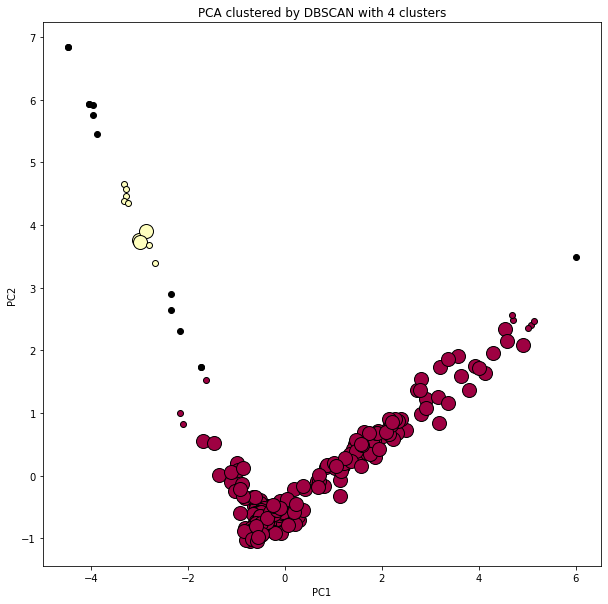

<Figure size 432x288 with 0 Axes>

In [6]:
n_clusters_ = 4

kmeans_obj_count = KMeans(n_clusters=n_clusters_, random_state=random_state)
kmeans_obj_count.fit(df_count)
labels_count = kmeans_obj_count.labels_
prediction_kmeans_count = kmeans_obj_count.predict(df_count)

pca_count = PCA(n_components=2, random_state=random_state)
reduced_features_count = pca_count.fit_transform(df_count)
reduced_cluster_centers_count = pca_count.transform(kmeans_obj_count.cluster_centers_)

db = DBSCAN(eps=1, min_samples=10).fit(reduced_features_count)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

plt.figure(figsize=(10, 10))

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = reduced_features_count[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    xy = reduced_features_count[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)


plt.title('PCA clustered by DBSCAN with %d clusters' % n_clusters_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
plt.savefig('clustering-dbscan-'+str(n_clusters_)+'.png')


## Hierarchical Clustering
- Dendrogram

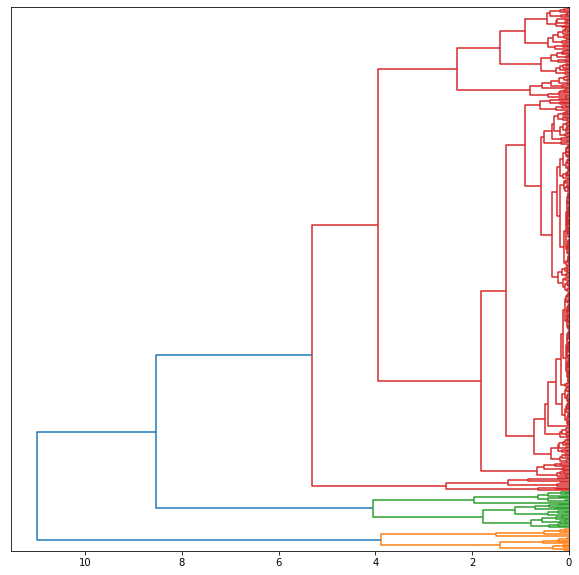

In [7]:
fig_den = plt.figure(figsize=(10, 10))
Z = linkage(squareform(np.around(euclidean_distances(reduced_features_count), decimals=4)), method='complete')
dendrogram(Z, orientation='left', no_labels=True)
fig_den.savefig('clustering-hierarchical-dendrogram.png')

## Selecting the optimal $k$ with visualization (find with Silouette)

For n_clusters = 2 The average silhouette_score is : 0.6787789989138412
For n_clusters = 3 The average silhouette_score is : 0.768746112778979
For n_clusters = 4 The average silhouette_score is : 0.7704509460154355
For n_clusters = 5 The average silhouette_score is : 0.7766547424798647


<Figure size 1440x720 with 0 Axes>

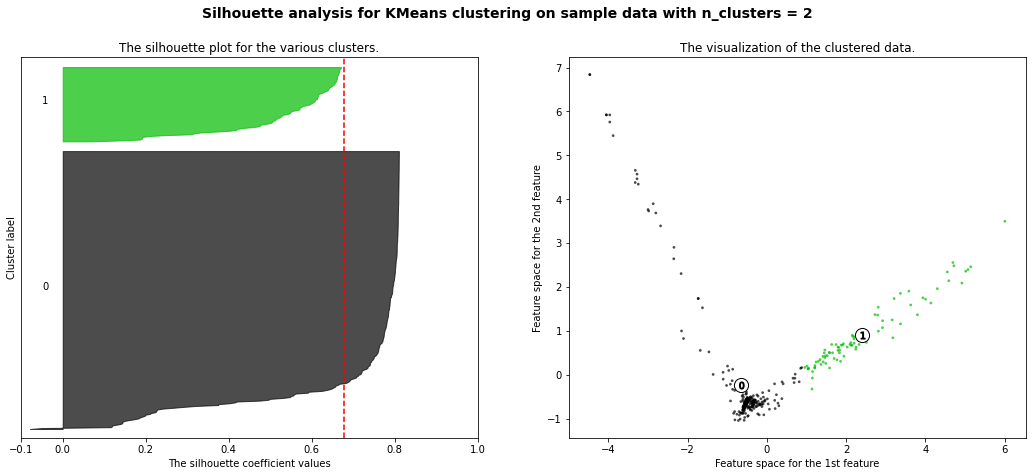

<Figure size 1440x720 with 0 Axes>

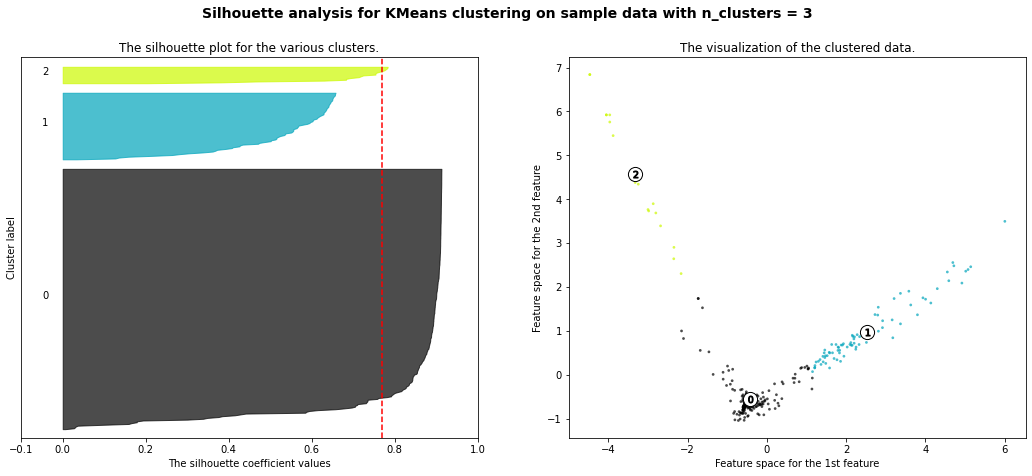

<Figure size 1440x720 with 0 Axes>

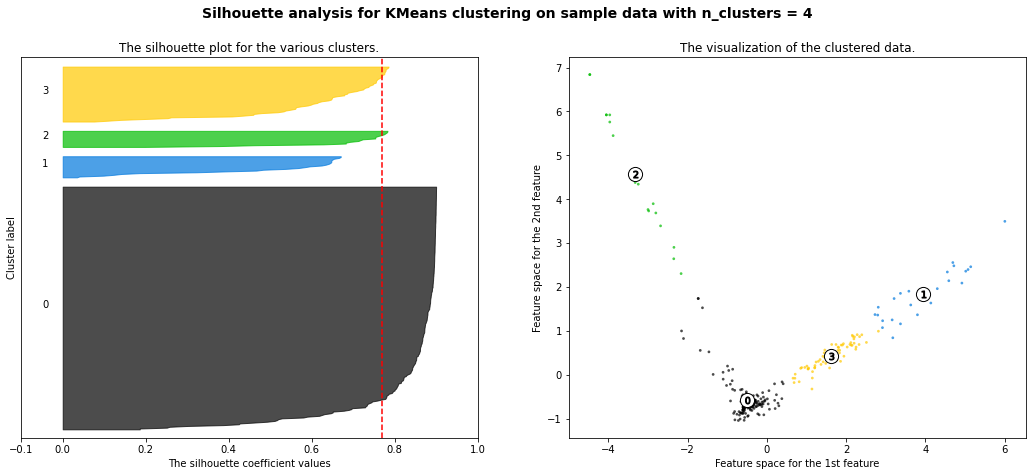

<Figure size 1440x720 with 0 Axes>

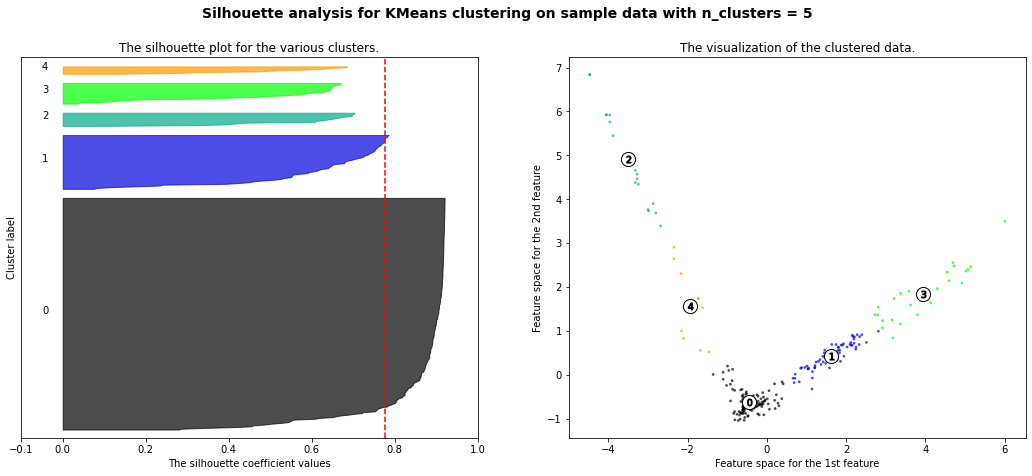

In [8]:
range_n_clusters = [2, 3, 4, 5]

X = reduced_features_count

for n_clusters in range_n_clusters:
    plt.figure(figsize=(20, 10))

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
        "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                            0, ith_cluster_silhouette_values,
                            facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
        "with n_clusters = %d" % n_clusters),
        fontsize=14, fontweight='bold')

    plt.savefig('clustering-find-optimal-k-'+str(n_clusters)+'.png')

plt.show()